# Newell-Lee Evaporator: Rolling Horizon Simulation

Solve the following IVP to simulate the Evaporator example from Pilario et al. (2021) in $t\in[0, 1000]$ min:

$$ \frac{dL_2}{dt} = \frac{F_1-F_4-F_2}{20}$$

$$ \frac{dX_2}{dt} = \frac{F_1 X_1 - F_2 X_2}{20} $$

$$ \frac{dP_2}{dt} = \frac{F_4 - F_5}{4} $$

Apply piecewise step changes on F200, P100, and F2 inputs every 10 min.


In [7]:
from scipy.integrate import solve_ivp
from pyomo.environ import *
from pyomo.dae import DerivativeVar, ContinuousSet
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
def solve_model(ti, tf, F200data, P100data, F2data, init_data):

    evap = ConcreteModel()

    evap.ti = Param(initialize=ti)
    evap.tf = Param(initialize=tf)
    evap.t = ContinuousSet(bounds=(evap.ti,evap.tf))

    # States
    evap.L2 = Var(evap.t, initialize=1, bounds=(0, 4))
    evap.P2 = Var(evap.t, initialize=50.5)
    evap.X2 = Var(evap.t, initialize=25)

    # Inputs and Disturbances
    evap.T200 = Param(evap.t, default=25)
    evap.F1 = Param(evap.t, default=10)
    evap.F3 = Param(evap.t, default=50)
    evap.X1 = Param(evap.t, default=5)
    evap.T1 = Param(evap.t, default=40)

    evap.F200 = Param(evap.t, mutable=True)  # Input to be manipulated
    evap.P100 = Param(evap.t, mutable=True)  # Input to be manipulated
    evap.F2 = Param(evap.t, mutable=True)    # Input to be manipulated

    # Other outputs
    evap.F4 = Var(evap.t, initialize=8)
    evap.F5 = Var(evap.t, initialize=8)
    evap.T2 = Var(evap.t, initialize=84.6)
    evap.T3 = Var(evap.t, initialize=80.6)
    evap.F100 = Var(evap.t, initialize=9.27)
    evap.T100 = Var(evap.t, initialize=119.9)
    evap.Q100 = Var(evap.t, initialize=339.2)
    evap.T201 = Var(evap.t, initialize=46.15)
    evap.Q200 = Var(evap.t, initialize=308)

    # Setup derivative vars for states
    evap.dL2dt = DerivativeVar(evap.L2, initialize=init_data['dL2dt'])
    evap.dP2dt = DerivativeVar(evap.P2, initialize=init_data['dP2dt'])
    evap.dX2dt = DerivativeVar(evap.X2, initialize=init_data['dX2dt'])

    # Set an objective
    evap.obj = Objective(expr=1)

    evap.z1dot = Constraint(evap.t, rule = lambda m, i: \
                           m.dL2dt[i]*20 == m.F1[i] - m.F4[i] - m.F2[i])
    evap.z2dot = Constraint(evap.t, rule = lambda m, i: \
                           m.dX2dt[i]*20 == m.F1[i]*m.X1[i] - m.F2[i]*m.X2[i])
    evap.z3dot = Constraint(evap.t, rule = lambda m, i: \
                           m.dP2dt[i]*4 == m.F4[i] - m.F5[i])

    # Other constraints
    evap.con1 = Constraint(evap.t, rule = lambda m, i: \
                          m.T2[i] == 0.5616*m.P2[i] + 0.3126*m.X2[i] + 48.43)
    evap.con2 = Constraint(evap.t, rule = lambda m, i: \
                          m.T3[i] == 0.507*m.P2[i] + 55)
    evap.con3 = Constraint(evap.t, rule = lambda m, i: \
                          m.F4[i]*38.5 == m.Q100[i] - 0.07*m.F1[i]*(m.T2[i] - m.T1[i]))
    evap.con4 = Constraint(evap.t, rule = lambda m, i: \
                          m.T100[i] == 0.1538*m.P100[i] + 90)
    evap.con5 = Constraint(evap.t, rule = lambda m, i: \
                          m.Q100[i] == 0.16*(m.F1[i] + m.F3[i])*(m.T100[i] - m.T2[i]))
    evap.con6 = Constraint(evap.t, rule = lambda m, i: \
                          m.F100[i]*36.6 == m.Q100[i])
    evap.con7 = Constraint(evap.t, rule = lambda m, i: \
                          m.Q200[i]*(0.14*m.F200[i]+6.84) == 0.9576*m.F200[i]*(m.T3[i]-m.T200[i]))
    evap.con8 = Constraint(evap.t, rule = lambda m, i:\
                          m.T201[i] == m.T200[i] + m.Q200[i]/0.07/m.F200[i])
    evap.con9 = Constraint(evap.t, rule = lambda m, i: \
                          m.F5[i]*38.5 == m.Q200[i])

    def _init(m):
        yield m.L2[evap.ti] == init_data['L2']
        yield m.P2[evap.ti] == init_data['P2']
        yield m.X2[evap.ti] == init_data['X2']
    
    evap.initcon = ConstraintList(rule=_init)

    # Discretize using collocation
    discretizer = TransformationFactory('dae.collocation')
    discretizer.apply_to(evap, nfe=20, ncp=3, scheme='LAGRANGE-RADAU')

    # Step change data
    timepoints = list(evap.t)
    if evap.ti.value == 0:
        F200data[0] = 208
        P100data[0] = 194.7
        F2data[0] = 2
    for i, t in enumerate(timepoints):
        pos = np.argwhere(t>=i_data)[-1]
        evap.F200[t] = F200data[pos][0]
        evap.P100[t] = P100data[pos][0]
        evap.F2[t] = F2data[pos][0]

    # Solve using Pyomo IPOPT
    solver = SolverFactory('cyipopt')
    res = solver.solve(evap)
    
    model_vars = evap.component_map(ctype=Var)
    model_params = evap.component_map(ctype=Param)

    s_list = []
    col_list = []
    ctr = 1
    for k in model_vars.keys():
        v = model_vars[k]
        s = pd.Series(v.extract_values(), 
                      index=v.extract_values().keys())
        s.sort_index(inplace=True)
        s_list.append(s)
        col_list.append(v.name)
        ctr += 1

    for k in model_params.keys():
        v = model_params[k]
        if v.name == 'F200' or v.name == 'P100' or v.name == 'F2':
            s = pd.Series(v.extract_values(), 
                          index=v.extract_values().keys())
            s.sort_index(inplace=True)
            s_list.append(s)
            col_list.append(v.name)
            ctr += 1

    evap_df = pd.concat(s_list, axis=1)
    evap_df.columns = col_list
    return evap_df, res
    
np.random.seed(3)
i_data = np.arange(0, 1000, 10) # start, last, increment
F200data = (np.random.rand(i_data.shape[0])-0.5)*20 + 208
P100data = (np.random.rand(i_data.shape[0])-0.5)*20 + 194.7
F2data = (np.random.rand(i_data.shape[0])-0.5)*0.5 + 2

init_data = {'L2':1,    'P2':50.5, 'X2':25,
             'dL2dt':0, 'dP2dt':0, 'dX2dt':0}

# Initialize the data frame
evap_df = pd.DataFrame(columns=['L2', 'P2', 'X2', 'F4', 'F5', 'T2', 'T3',
                                'F100', 'T100', 'Q100', 'T201', 'Q200', 'dL2dt', 
                                'dP2dt', 'dX2dt', 'F200', 'P100', 'F2'])

for j in np.arange(0, 1000, 20): # start, last, increment
    
    # Simulate the model at time [j, j+20]
    temp_df, res = solve_model(j, j+20, F200data, P100data, F2data, init_data)
    print(f"Time: {j} min to {j+20} min")
    print(f"Status: {res.Solver.status}")
    
    # Save the last condition as the next initial condition
    for k in init_data.keys():
        init_data[k] = temp_df.iloc[-1][k]

    # Append temp_df after evap_df
    if j < 1000:
        evap_df = pd.concat([evap_df, temp_df.iloc[:-1,:]], axis=0)
    else:
        evap_df = pd.concat([evap_df, temp_df], axis=0)
        

Please recompile / update your pynumero_ASL library.
Time: 0 min to 20 min
Status: ok
Time: 20 min to 40 min
Status: ok
Time: 40 min to 60 min
Status: ok
Time: 60 min to 80 min
Status: ok
Time: 80 min to 100 min
Status: ok
Time: 100 min to 120 min
Status: ok
Time: 120 min to 140 min
Status: ok
Time: 140 min to 160 min
Status: ok
Time: 160 min to 180 min
Status: ok
Time: 180 min to 200 min
Status: ok
Time: 200 min to 220 min
Status: ok
Time: 220 min to 240 min
Status: ok
Time: 240 min to 260 min
Status: ok
Time: 260 min to 280 min
Status: ok
Time: 280 min to 300 min
Status: ok
Time: 300 min to 320 min
Status: ok
Time: 320 min to 340 min
Status: ok
Time: 340 min to 360 min
Status: ok
Time: 360 min to 380 min
Status: ok
Time: 380 min to 400 min
Status: ok
Time: 400 min to 420 min
Status: ok
Time: 420 min to 440 min
Status: ok
Time: 440 min to 460 min
Status: ok
Time: 460 min to 480 min
Status: ok
Time: 480 min to 500 min
Status: ok
Time: 500 min to 520 min
Status: ok
Time: 520 min to 540 

In [3]:
evap_df.shape

(3000, 18)

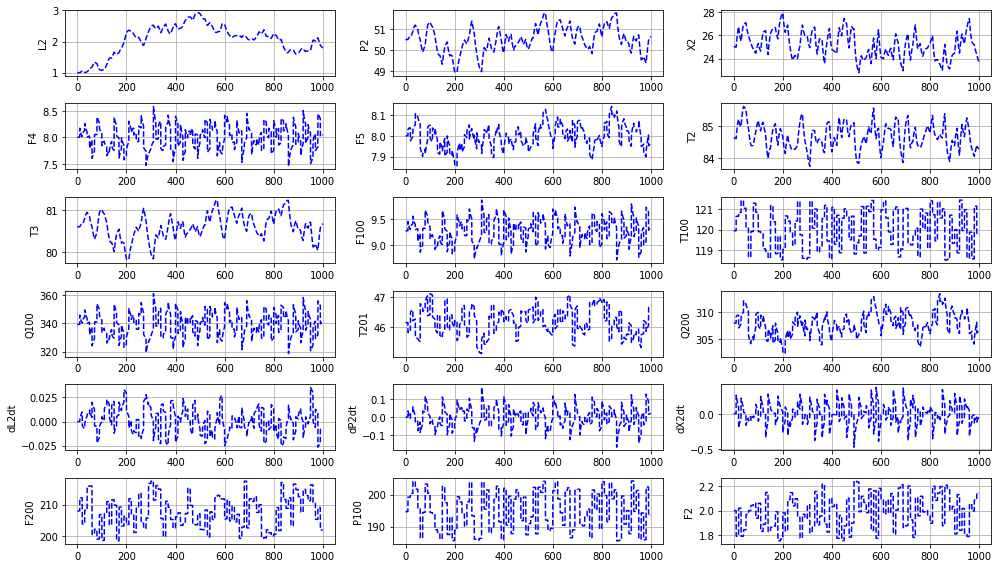

In [4]:
ctr = 1
plt.figure(figsize=(14, 8))
for k in evap_df.columns:
    plt.subplot(6, 3, ctr)
    plt.plot(evap_df[k].index, evap_df[k].values,'b--')
    plt.grid()
    plt.ylabel(k)
    ctr += 1
    
plt.tight_layout()
plt.show()

In [5]:
evap_df.head(10)

,L2,P2,X2,F4,F5,T2,T3,F100,T100,Q100,T201,Q200,dL2dt,dP2dt,dX2dt,F200,P100,F2
0.000000,1.000000,50.500000,25.0,8.000803,7.999617,84.605800,80.603500,9.269262,119.94486,339.254976,46.152833,307.985251,-0.000040,0.000297,0.000000e+00,208.0,194.7,2.0
0.155051,0.999994,50.500046,25.0,8.000796,7.999620,84.605826,80.603523,9.269255,119.94486,339.254729,46.152842,307.985379,-0.000040,0.000294,-2.723411e-16,208.0,194.7,2.0
0.644949,0.999975,50.500188,25.0,8.000775,7.999631,84.605905,80.603595,9.269234,119.94486,339.253963,46.152869,307.985778,-0.000039,0.000286,1.721923e-15,208.0,194.7,2.0
1.000000,0.999961,50.500288,25.0,8.000760,7.999638,84.605962,80.603646,9.269219,119.94486,339.253421,46.152889,307.986061,-0.000038,0.000280,5.067597e-15,208.0,194.7,2.0
1.155051,0.999955,50.500332,25.0,8.000753,7.999641,84.605986,80.603668,9.269213,119.94486,339.253188,46.152897,307.986182,-0.000038,0.000278,4.717288e-15,208.0,194.7,2.0
1.644949,0.999937,50.500466,25.0,8.000733,7.999651,84.606062,80.603736,9.269193,119.94486,339.252463,46.152923,307.986559,-0.000037,0.000271,6.473002e-15,208.0,194.7,2.0
2.000000,0.999924,50.500561,25.0,8.000719,7.999658,84.606115,80.603785,9.269179,119.94486,339.251951,46.152941,307.986827,-0.000036,0.000265,9.652948e-15,208.0,194.7,2.0
2.155051,0.999918,50.500602,25.0,8.000713,7.999661,84.606138,80.603805,9.269173,119.94486,339.251730,46.152949,307.986942,-0.000036,0.000263,9.232092e-15,208.0,194.7,2.0
2.644949,0.999901,50.500729,25.0,8.000693,7.999670,84.606210,80.603870,9.269154,119.94486,339.251045,46.152974,307.987298,-0.000035,0.000256,1.077196e-14,208.0,194.7,2.0
3.000000,0.999889,50.500819,25.0,8.000680,7.999677,84.606260,80.603915,9.269141,119.94486,339.250560,46.152991,307.987551,-0.000034,0.000251,1.380194e-14,208.0,194.7,2.0


In [6]:
evap_df.tail(10)

,L2,P2,X2,F4,F5,T2,T3,F100,T100,Q100,T201,Q200,dL2dt,dP2dt,dX2dt,F200,P100,F2
996.644949,1.818858,50.595821,23.831838,8.042537,7.961068,84.294445,80.652081,9.307207,119.778172,340.643777,46.683947,306.501135,-0.009398,0.020367,-0.056474,201.927612,193.616204,2.145427
997.000000,1.815516,50.603054,23.812164,8.043095,7.961593,84.292358,80.655748,9.307755,119.778172,340.663820,46.685376,306.521333,-0.009426,0.020376,-0.054363,201.927612,193.616204,2.145427
997.155051,1.814054,50.606213,23.803805,8.043320,7.961822,84.291519,80.657350,9.307975,119.778172,340.671873,46.686000,306.530154,-0.009437,0.020374,-0.053466,201.927612,193.616204,2.145427
997.644949,1.809423,50.616190,23.778288,8.043955,7.962546,84.289145,80.662408,9.308597,119.778172,340.694658,46.687971,306.558013,-0.009469,0.020352,-0.050729,201.927612,193.616204,2.145427
998.000000,1.806057,50.623411,23.760615,8.044348,7.963069,84.287676,80.666069,9.308983,119.778172,340.708764,46.689397,306.578175,-0.009489,0.020320,-0.048833,201.927612,193.616204,2.145427
998.155051,1.804585,50.626560,23.753106,8.044503,7.963298,84.287097,80.667666,9.309134,119.778172,340.714320,46.690020,306.586969,-0.009496,0.020301,-0.048028,201.927612,193.616204,2.145427
998.644949,1.799927,50.636489,23.730185,8.044928,7.964018,84.285508,80.672700,9.309551,119.778172,340.729578,46.691981,306.614691,-0.009518,0.020227,-0.045569,201.927612,193.616204,2.145427
999.000000,1.796546,50.643659,23.714310,8.045178,7.964538,84.284572,80.676335,9.309797,119.778172,340.738562,46.693397,306.634712,-0.009530,0.020160,-0.043866,201.927612,193.616204,2.145427
999.155051,1.795068,50.646782,23.707565,8.045273,7.964765,84.284217,80.677918,9.309890,119.778172,340.741965,46.694014,306.643434,-0.009535,0.020127,-0.043143,201.927612,193.616204,2.145427
999.644949,1.790393,50.656614,23.686975,8.045518,7.965478,84.283303,80.682903,9.310130,119.778172,340.750744,46.695957,306.670888,-0.009547,0.020010,-0.040934,201.927612,193.616204,2.145427
